In [1]:
from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

jax.config.update("jax_enable_x64", True)

## Reading and Displaying Fits File

In [2]:
def process_image(image, scale_factor=1, offset=1):
    scaled_image = (image[::scale_factor, ::scale_factor])[1::, 1::]
    cropped_image = image[70:210, 70:210]
    def safe_float32_conversion(value):
        try:
            return np.float32(value)
        except (ValueError, TypeError):
            print("This value is unjaxable: " + str(value))
    fin_image = np.nan_to_num(cropped_image)
    fin_image = np.vectorize(safe_float32_conversion)(fin_image)
    return fin_image

Filename: Fits/aumic_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     482   ()      
  1  SCI           1 ImageHDU       140   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


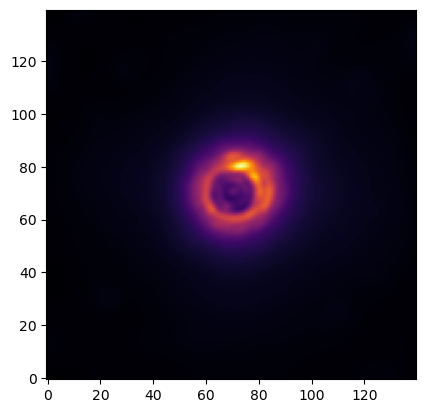

In [3]:
fits_image_filepath = "Fits/aumic_H_pol.fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
image = process_image(hdul['SCI'].data[0,:,:])

# Displays Image
plt.imshow(image, origin='lower', cmap='inferno')

## Displaying All Fits Files

In [4]:

fnames = os.listdir("Fits/")
print(fnames)

scale_factor = 1
images = []
ignore_fits = ['systempsf.fits']

for fname in fnames:
    if(fname in ignore_fits):
        continue
    hdul = fits.open("Fits/"+fname)
    image = process_image(hdul['SCI'].data[1,:,:])
    images.append(image)

['hd145560_H_pol.fits', 'hd146897_H_pol.fits', 'ceant_H_pol.fits', 'hd61005_H_pol.fits', 'systempsf.fits', 'hd111520_H_pol.fits', 'hd115600_H_pol.fits', 'hd129590_H_pol.fits', 'hd117214_H_pol.fits', 'betpic_H_pol.fits', 'hd35841_H_pol.fits', 'hd30447_H_pol.fits', 'hr7012_H_pol.fits', 'hd32297_H_pol.fits', 'hd110058_H_pol.fits', 'hd111161_H_pol.fits', 'hd157587_H_pol.fits', 'hr4796a_H_pol.fits', 'aumic_H_pol.fits', 'hd143675_H_pol.fits', 'hd131835_H_pol.fits', 'hd106906_H_pol.fits', 'hd114082_H_pol.fits', 'hd191089_H_pol.fits', 'hd156623_H_pol.fits']


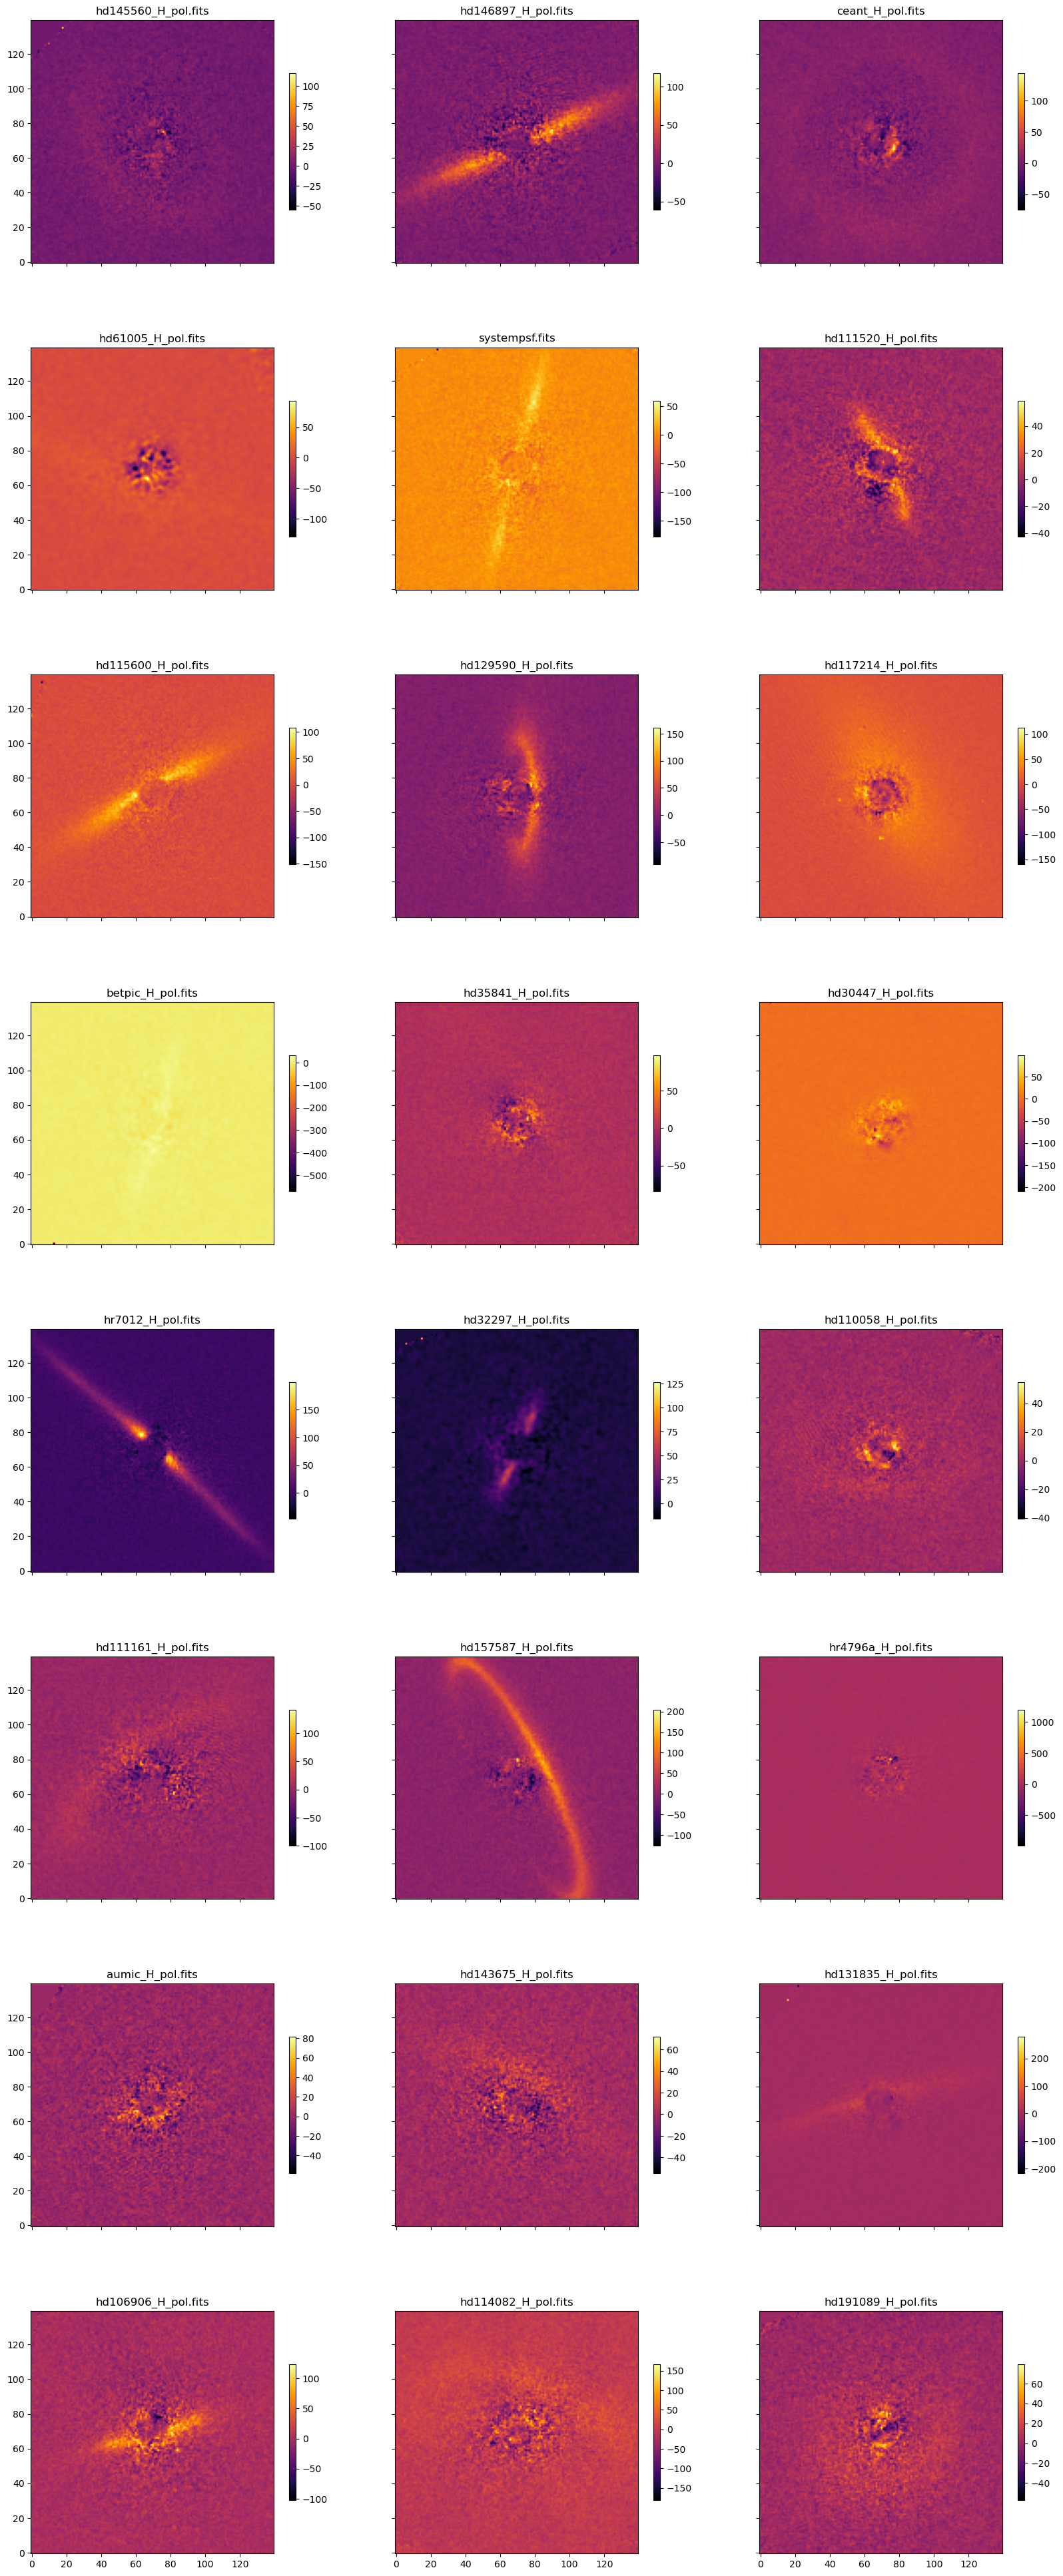

In [5]:
fig, axes = plt.subplots(8,3, sharex=True, sharey=True, figsize = (20,50))

for i in range(0, 8):
    for j in range(0, 3):
        im = axes[i][j].imshow(images[3*i+j], origin='lower', cmap='inferno')
        axes[i][j].set_title(fnames[3*i+j])
        plt.colorbar(im,ax=axes[i][j], shrink=0.5)

## Fitting Disk Models to Fits Images

In [6]:
from disk_utils_jax import jax_model_all_1d
from regression import log_likelihood_1d_pos_all_pars_spline
from scipy.optimize import minimize
from SLD_utils import *

In [7]:
# Creating error map
def create_circular_err_map(image_shape, iradius, oradius, noise_level):
    err_map = jnp.zeros(image_shape)
    center = image_shape[0]/2
    y, x = jnp.ogrid[:image_shape[0], :image_shape[1]]
    distance = jnp.sqrt((x - center) ** 2 + (y - center) ** 2)  
    err_map = jnp.where(distance <= oradius, noise_level, 1e8)
    err_map = jnp.where(distance >= iradius, err_map, 1e8)
    return err_map

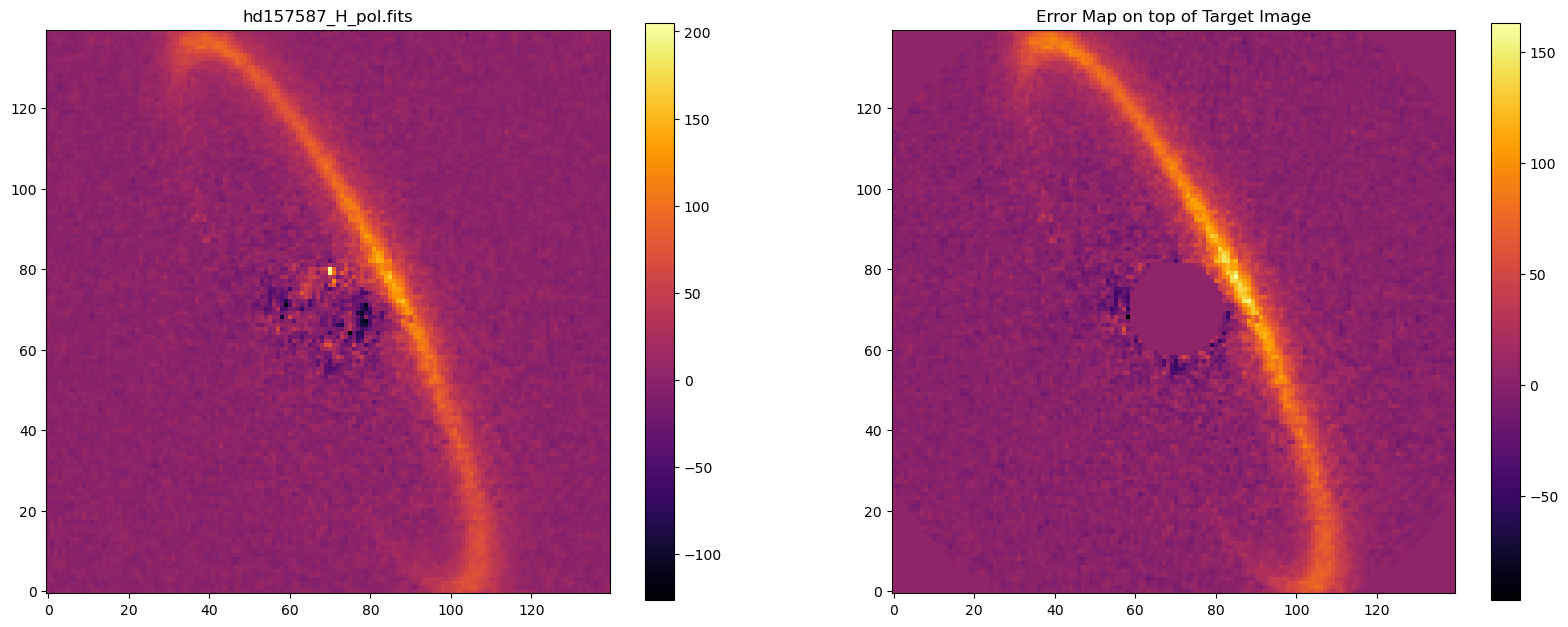

In [8]:
target_image = jnp.asarray(images[16])

fig, axes = plt.subplots(1, 2, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap = 'inferno')
axes[0].set_title(fnames[16])
plt.colorbar(im, ax=axes[0], shrink=0.75)

noise_level = 5
err_map = create_circular_err_map(target_image.shape, 12, 83, noise_level)
overlayed_image = jnp.where(err_map == 1e8, noise_level, target_image)
im = axes[1].imshow(overlayed_image, origin='lower', cmap = 'inferno')
axes[1].set_title("Error Map on top of Target Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

In [9]:

# Parameters
disk_params = {}
disk_params['inclination'] = 40. #In degrees
disk_params['position_angle'] = 50. #In Degrees
disk_params['alpha_in'] = 8. #The inner power law
disk_params['alpha_out'] = -5. #The outer power law
disk_params['flux_scaling'] = 1e6
disk_params['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

disk_params_1d = np.array([disk_params['alpha_in'], disk_params['alpha_out'], disk_params['sma'], disk_params['inclination'],
                           disk_params['position_angle']])
spline_params_1d= jnp.full(6, 0.05)   # random knot y-values
all_pars_spline = jnp.concatenate([disk_params_1d, spline_params_1d])

In [10]:
# Have to input spline parameters like this for the method to work
init_disk = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, all_pars_spline[0:5],
                                            InterpolatedUnivariateSpline_SPF.pack_pars(all_pars_spline[5:]), disk_params['flux_scaling'])

#plt.imshow(init_disk, origin='lower', cmap='inferno')
#plt.title("Initial Guess")

In [11]:
print(log_likelihood_1d_pos_all_pars_spline(all_pars_spline, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        disk_params['flux_scaling'], target_image, err_map))

1572026.4552145256


In [12]:
llp = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        disk_params['flux_scaling'], target_image, err_map, pxInArcsec=0.01414)

opt = {'disp':True,'maxiter':3000}
soln_spline = minimize(llp, all_pars_spline, options=opt, method = None)

print(soln_spline)

         Current function value: 76969.764440
         Iterations: 86
         Function evaluations: 1680
         Gradient evaluations: 139
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 76969.7644403992
        x: [ 1.702e+01 -9.989e+00  5.288e+01  7.719e+01  2.701e+01
             6.594e-02  2.398e-02  2.295e-02  1.327e-02  6.504e-03
            -3.132e-03]
      nit: 86
      jac: [ 0.000e+00  0.000e+00  0.000e+00  9.766e-04  9.766e-04
             9.766e-04  3.027e-02 -6.836e-03  2.246e-02  2.246e-02
            -1.562e-02]
 hess_inv: [[ 1.511e-01  5.104e-02 ...  7.594e-06 -3.014e-06]
            [ 5.104e-02  3.809e-02 ... -1.013e-06  3.894e-06]
            ...
            [ 7.594e-06 -1.013e-06 ...  1.262e-08 -9.848e-09]
            [-3.014e-06  3.894e-06 ... -9.848e-09  3.765e-08]]
     nfev: 1680
     njev: 139


/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [13]:
# Have to input spline parameters like this for the method to work
disk_image_fit_spline = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, soln_spline.x[0:5],
                                            InterpolatedUnivariateSpline_SPF.pack_pars(soln_spline.x[5:]), disk_params['flux_scaling'],
                                            pxInArcsec=0.01414)

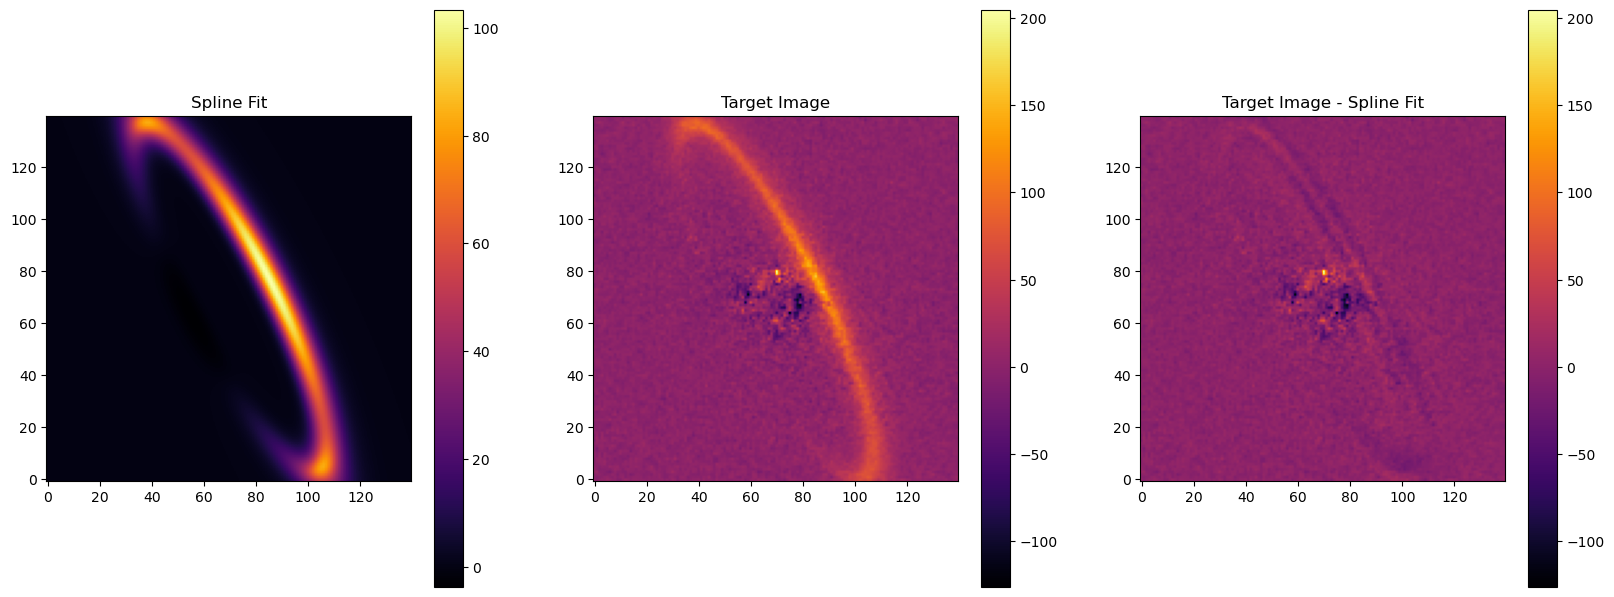

In [14]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(disk_image_fit_spline, origin='lower', cmap='inferno')
axes[0].set_title("Spline Fit")
plt.colorbar(im, ax=axes[0], shrink=0.75)

im = axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

im = axes[2].imshow(target_image-disk_image_fit_spline, origin='lower', cmap='inferno')
axes[2].set_title("Target Image - Spline Fit")
plt.colorbar(im, ax=axes[2], shrink=0.75)

In [15]:
print(log_likelihood_1d_pos_all_pars_spline(all_pars_spline, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        disk_params['flux_scaling'], target_image, err_map, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414))

643012238.0579576


In [16]:
from optimize import quick_optimize, quick_image

err_map = create_circular_err_map(target_image.shape, 12, 83, 5)
soln = quick_optimize(target_image, err_map, method = None, iters = 2000, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414)

disk_image_fit_spline = quick_image(soln, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 79180.1489067883
        x: [ 1.415e+01 -1.993e+01  5.448e+01  7.802e+01  2.717e+01
             4.375e-03  1.530e-03  1.366e-03  8.862e-04  4.030e-04
            -2.431e-04]
      nit: 153
      jac: [-2.818e-06 -3.444e-07 -7.268e-06  1.811e-05 -5.680e-07
             2.657e-03  6.800e-03  4.396e-04  1.175e-02  2.016e-02
            -3.576e-03]
 hess_inv: [[ 1.101e-01  1.617e-01 ...  7.274e-07 -5.793e-07]
            [ 1.617e-01  6.614e-01 ... -1.374e-06  1.146e-06]
            ...
            [ 7.274e-07 -1.374e-06 ...  7.705e-11 -5.333e-11]
            [-5.793e-07  1.146e-06 ... -5.333e-11  1.832e-10]]
     nfev: 178
     njev: 178


In [17]:
from regression import log_likelihood_1d_pos_cent

jax.config.update("jax_debug_nans", True)

init_knot_guess = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi([0.5, 0.5, 0.5], jnp.linspace(1, -1, 6))
init_disk_guess = jnp.array([5., -5., 45., 45, 45])
init_cent_guess = jnp.array([70., 70.])
init_guess = jnp.concatenate([init_cent_guess, init_disk_guess, init_knot_guess])
llp = lambda x: log_likelihood_1d_pos_cent(x, 
                    DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                    1e6, target_image, err_map, PSFModel = GAUSSIAN_PSF, pxInArcsec=0.01414)
grad_func = jax.grad(llp)
print(grad_func(init_guess))

[ 2.23680173e+06  2.12194606e+06 -1.00996679e+08  8.43508922e+07
 -4.55352747e+07  7.80043653e+07 -2.48164908e+04  5.32100965e+08
  1.18654483e+10  2.25515447e+09  2.30493898e+09  2.15664643e+09
  6.45781740e+07]


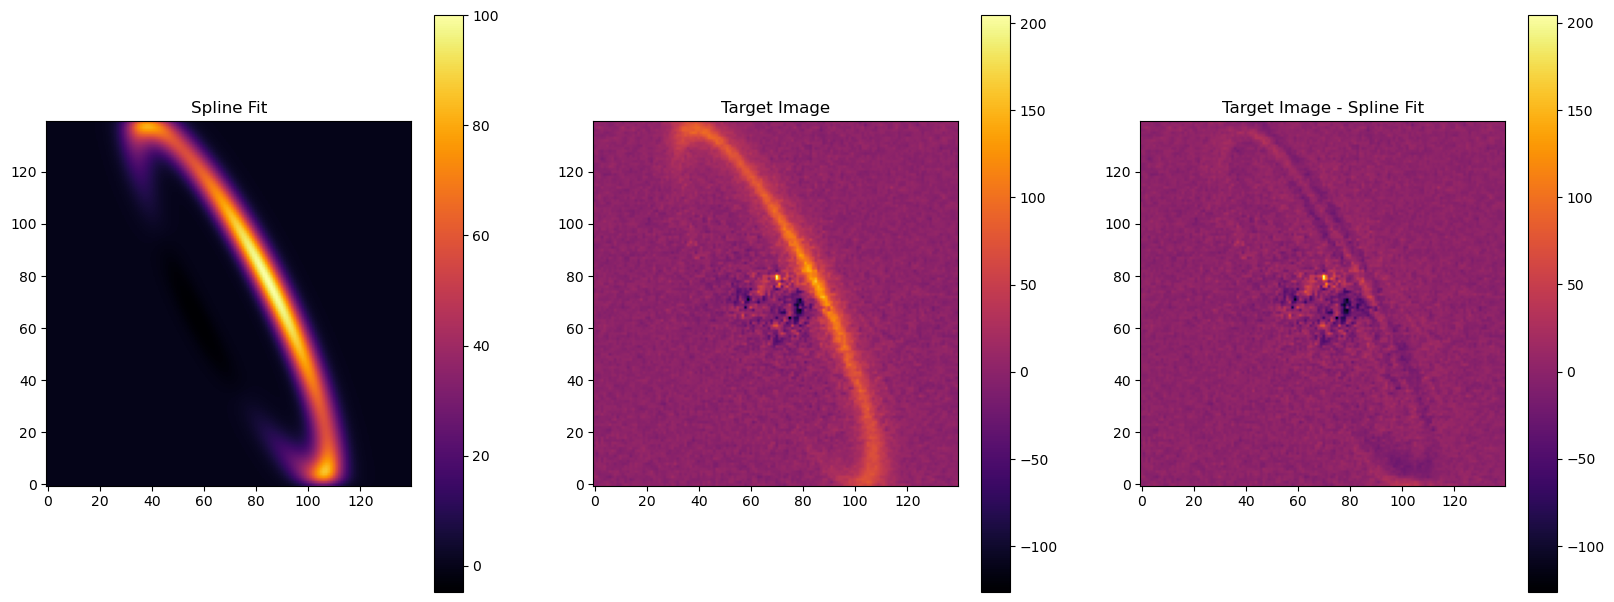

In [18]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(disk_image_fit_spline, origin='lower', cmap='inferno')
axes[0].set_title("Spline Fit")
plt.colorbar(im, ax=axes[0], shrink=0.75)

im = axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

im = axes[2].imshow(target_image - disk_image_fit_spline, origin='lower', cmap='inferno')
axes[2].set_title("Target Image - Spline Fit")
plt.colorbar(im, ax=axes[2], shrink=0.75)

## Shifting Image Center

In [19]:
from optimize import quick_optimize_cent, quick_image_cent

In [20]:
FULL_BOUNDS = [(65, 75), (65, 75), (1, 10), (-1, 10), (10, 80), (0, 180), (0, 180),
              (0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)]

err_map = create_circular_err_map(target_image.shape, 12, 83, 15)
soln = quick_optimize_cent(target_image, err_map, method = None, iters = 2000, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414, distance = 70.77)
print(soln)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 79346.32968365058
        x: [ 6.800e+01  6.835e+01 ...  5.182e-04 -1.548e-04]
      nit: 161
      jac: [ 7.676e-01  2.344e-02 ...  6.658e+00  2.957e+00]
 hess_inv: [[ 1.857e-06  1.010e-05 ... -3.098e-09  9.435e-10]
            [ 1.010e-05  1.013e-02 ...  3.019e-07 -5.783e-07]
            ...
            [-3.098e-09  3.019e-07 ...  9.755e-10 -7.821e-10]
            [ 9.435e-10 -5.783e-07 ... -7.821e-10  2.911e-09]]
     nfev: 3584
     njev: 256
[ 6.80000000e+01  6.83454252e+01  1.55469676e+01 -7.92049597e+00
  7.57434411e+01  7.66719570e+01  2.68552666e+01  5.48960221e-03
  2.08793482e-03  2.41890086e-03  1.33933929e-03  5.18222144e-04
 -1.54764273e-04]


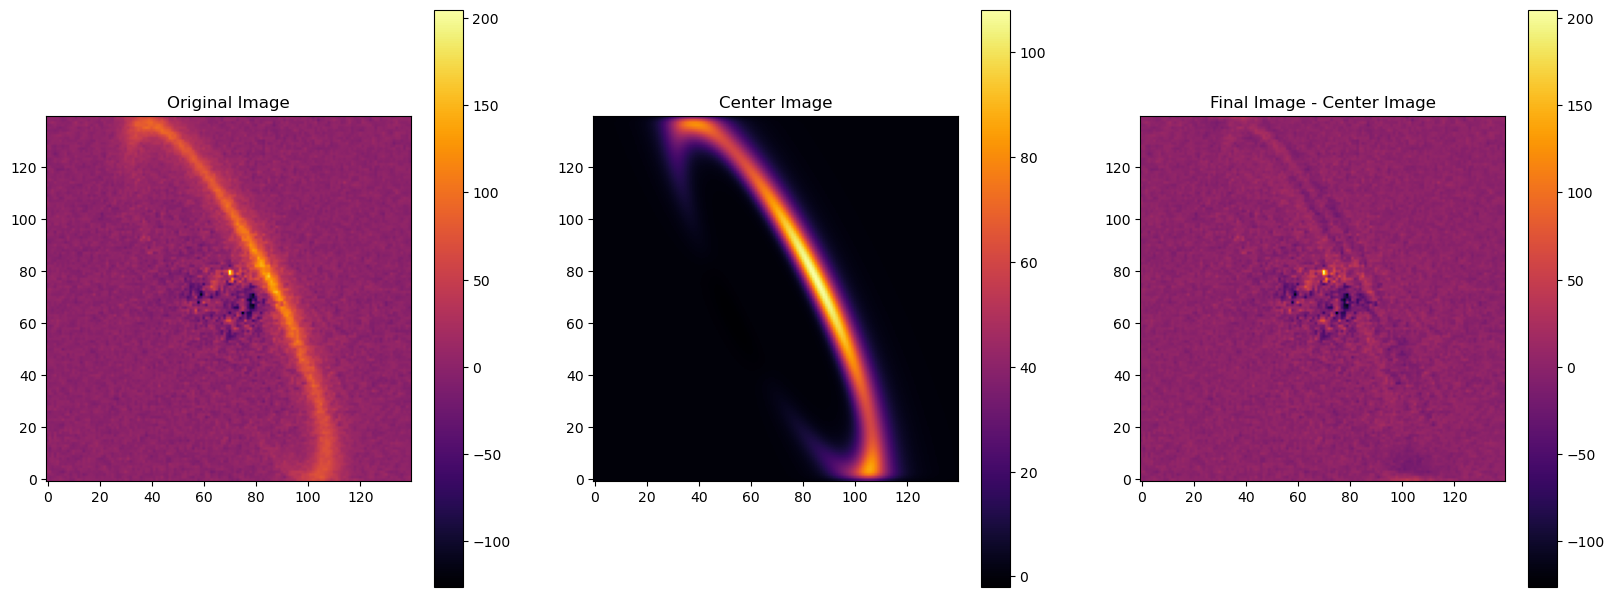

In [21]:
cent_image = quick_image_cent(soln, PSFModel = GAUSSIAN_PSF, pxInArcsec=0.01414, distance = 70.77)

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)

im = axes[1].imshow(cent_image, origin='lower', cmap='inferno')
axes[1].set_title("Center Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

im = axes[2].imshow(target_image-cent_image, origin='lower', cmap='inferno')
axes[2].set_title("Final Image - Center Image")
plt.colorbar(im, ax=axes[2], shrink=0.75)

## Fitting Distribution Parameters as Well

In [22]:
from optimize import quick_optimize_full_opt, quick_image_full_opt

In [23]:

'''err_map = create_circular_err_map(target_image.shape, 12, 83, 15)
soln = quick_optimize_full_opt(target_image, err_map, method = None, iters = 2000, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414, distance = 70.77)
print(soln)'''

'err_map = create_circular_err_map(target_image.shape, 12, 83, 15)\nsoln = quick_optimize_full_opt(target_image, err_map, method = None, iters = 2000, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414, distance = 70.77)\nprint(soln)'

In [24]:
'''cent_image = quick_image_cent(soln, PSFModel = GAUSSIAN_PSF, pxInArcsec=0.01414, distance = 70.77)

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)

im = axes[1].imshow(cent_image, origin='lower', cmap='inferno')
axes[1].set_title("Center Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)

im = axes[2].imshow(target_image-cent_image, origin='lower', cmap='inferno')
axes[2].set_title("Final Image - Center Image")
plt.colorbar(im, ax=axes[2], shrink=0.75)'''

'cent_image = quick_image_cent(soln, PSFModel = GAUSSIAN_PSF, pxInArcsec=0.01414, distance = 70.77)\n\nfig, axes = plt.subplots(1,3, figsize=(20,10))\n\nim = axes[0].imshow(target_image, origin=\'lower\', cmap=\'inferno\')\naxes[0].set_title("Original Image")\nplt.colorbar(im, ax=axes[0], shrink=0.75)\n\nim = axes[1].imshow(cent_image, origin=\'lower\', cmap=\'inferno\')\naxes[1].set_title("Center Image")\nplt.colorbar(im, ax=axes[1], shrink=0.75)\n\nim = axes[2].imshow(target_image-cent_image, origin=\'lower\', cmap=\'inferno\')\naxes[2].set_title("Final Image - Center Image")\nplt.colorbar(im, ax=axes[2], shrink=0.75)'

## MCMC Model Time!

In [25]:
'''inc = soln[3]
print(inc)

KNOTS = 6

from mcmc_model import MCMC_model
from datetime import datetime'''

'inc = soln[3]\nprint(inc)\n\nKNOTS = 6\n\nfrom mcmc_model import MCMC_model\nfrom datetime import datetime'

In [26]:

'''llc = lambda theta: -log_likelihood_1d_pos_cent(theta, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                                        init_params['flux_scaling'],
                                        target_image, err_map, knots=jnp.linspace(1,-1,KNOTS),
                                        PSFModel = GAUSSIAN_PSF)

#init_disk_params = jnp.array([init_params['alpha_in'], init_params['alpha_out'], init_params['sma'], init_params['inclination'],
#                           init_params['position_angle']])

DISK_BOUNDS = np.array([np.array([65, 65, 1, -10, 10, 0, 0]), np.array([75, 75, 10, -1, 80, 180, 180])])
SPLINE_BOUNDS = np.array([np.zeros(KNOTS), np.ones(KNOTS)])
BOUNDS = np.array([np.concatenate([DISK_BOUNDS[0], SPLINE_BOUNDS[0]]), np.concatenate([DISK_BOUNDS[1], SPLINE_BOUNDS[1]])])

start = datetime.now()
mc_model = MCMC_model(llc, BOUNDS)
mc_model.run(soln, nconst = 1e-7)
labels = ['xc', 'yc', 'alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle']
for i in range(0, KNOTS):
    labels.append('k'+str(i+1))
mc_model.show_corner_plot(labels, truths=soln_spline.x)
end = datetime.now()
print(end-start)'''

"llc = lambda theta: -log_likelihood_1d_pos_cent(theta, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,\n                                        init_params['flux_scaling'],\n                                        target_image, err_map, knots=jnp.linspace(1,-1,KNOTS),\n                                        PSFModel = GAUSSIAN_PSF)\n\n#init_disk_params = jnp.array([init_params['alpha_in'], init_params['alpha_out'], init_params['sma'], init_params['inclination'],\n#                           init_params['position_angle']])\n\nDISK_BOUNDS = np.array([np.array([65, 65, 1, -10, 10, 0, 0]), np.array([75, 75, 10, -1, 80, 180, 180])])\nSPLINE_BOUNDS = np.array([np.zeros(KNOTS), np.ones(KNOTS)])\nBOUNDS = np.array([np.concatenate([DISK_BOUNDS[0], SPLINE_BOUNDS[0]]), np.concatenate([DISK_BOUNDS[1], SPLINE_BOUNDS[1]])])\n\nstart = datetime.now()\nmc_model = MCMC_model(llc, BOUNDS)\nmc_model.run(soln, nconst = 1e-7)\nlabels = ['xc', 'yc', 'alpha_in', 'alpha_out', 'sma', 